In [12]:
file_path = "/usr/local/lib/python3.11/dist-packages/basicsr/data/degradations.py"

with open(file_path, "r") as file:
    lines = file.readlines()

with open(file_path, "w") as file:
    for line in lines:
        if "from torchvision.transforms.functional_tensor import rgb_to_grayscale" in line:
            line = "from torchvision.transforms.functional import rgb_to_grayscale\n"
        file.write(line)


In [7]:
# Clone realESRGAN
!git clone https://github.com/xinntao/Real-ESRGAN.git
%cd Real-ESRGAN
# Set up the environment
!pip install basicsr
!pip install facexlib
!pip install gfpgan
!pip install -r requirements.txt
!python setup.py develop

# Clone BSRGAN
!git clone https://github.com/cszn/BSRGAN.git

# Download the pre-trained models
!wget https://github.com/cszn/KAIR/releases/download/v1.0/BSRGAN.pth -P BSRGAN/model_zoo
!wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth -P experiments/pretrained_models

Cloning into 'Real-ESRGAN'...
remote: Enumerating objects: 759, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 759 (delta 106), reused 99 (delta 99), pack-reused 638 (from 1)
Receiving objects: 100% (759/759), 5.38 MiB | 9.98 MiB/s, done.
Resolving deltas: 100% (415/415), done.
/content/Real-ESRGAN/Real-ESRGAN/Real-ESRGAN
/usr/local/lib/python3.11/dist-packages/setuptools/__init__.py:94: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************************************************
        Requirements should be satisfied by a PEP 517 installer.
        If you are using pip, you can try `pip install --use-pep517`.
        ********************************************************************************

!!
  dist.fetch_build_eggs(dist.setup_requires)
running develop
/usr/local/lib/python3.11/dist-packages/setuptools/command/develop.py:41: Eas

# 2. Upload Images

Upload the images to be processed by SwinIR

In [16]:
import os
import glob
from google.colab import files
import shutil
print(' Note1: You can find an image on the web or download images from the RealSRSet (proposed in BSRGAN, ICCV2021) at https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/RealSRSet+5images.zip.\n Note2: You may need Chrome to enable file uploading!\n Note3: If out-of-memory, set test_patch_wise = True.\n')

# test SwinIR by partioning the image into patches
test_patch_wise = True

# to be compatible with BSRGAN
!rm -r BSRGAN/testsets/RealSRSet
upload_folder = 'BSRGAN/testsets/RealSRSet'
result_folder = 'results'

if os.path.isdir(upload_folder):
    shutil.rmtree(upload_folder)
if os.path.isdir(result_folder):
    shutil.rmtree(result_folder)
os.mkdir(upload_folder)
os.mkdir(result_folder)

# upload images
uploaded = files.upload()
for filename in uploaded.keys():
  dst_path = os.path.join(upload_folder, filename)
  print(f'move {filename} to {dst_path}')
  shutil.move(filename, dst_path)

 Note1: You can find an image on the web or download images from the RealSRSet (proposed in BSRGAN, ICCV2021) at https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/RealSRSet+5images.zip.
 Note2: You may need Chrome to enable file uploading!
 Note3: If out-of-memory, set test_patch_wise = True.



Saving image.png to image.png
move image.png to BSRGAN/testsets/RealSRSet/image.png


# 3. Inference


In [17]:
# BSRGAN
!rm -r results
if not test_patch_wise:
  %cd BSRGAN
  !python main_test_bsrgan.py
  %cd ..
  shutil.move('BSRGAN/testsets/RealSRSet_results_x4', 'results/BSRGAN')

# realESRGAN
if test_patch_wise:
  !python inference_realesrgan.py -n RealESRGAN_x4plus --input BSRGAN/testsets/RealSRSet -s 4 --output results/realESRGAN --tile 800
else:
  !python inference_realesrgan.py -n RealESRGAN_x4plus --input BSRGAN/testsets/RealSRSet -s 4 --output results/realESRGAN

# SwinIR
if test_patch_wise:
  !python SwinIR/main_test_swinir.py --task real_sr --model_path experiments/pretrained_models/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth --folder_lq BSRGAN/testsets/RealSRSet --scale 4 --tile 800
else:
  !python SwinIR/main_test_swinir.py --task real_sr --model_path experiments/pretrained_models/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth --folder_lq BSRGAN/testsets/RealSRSet --scale 4
shutil.move('results/swinir_real_sr_x4', 'results/SwinIR')

# SwinIR-Large
if test_patch_wise:
  !python SwinIR/main_test_swinir.py --task real_sr --model_path experiments/pretrained_models/003_realSR_BSRGAN_DFOWMFC_s64w8_SwinIR-L_x4_GAN.pth --folder_lq BSRGAN/testsets/RealSRSet --scale 4 --large_model --tile 640
else:
  !python SwinIR/main_test_swinir.py --task real_sr --model_path experiments/pretrained_models/003_realSR_BSRGAN_DFOWMFC_s64w8_SwinIR-L_x4_GAN.pth --folder_lq BSRGAN/testsets/RealSRSet --scale 4 --large_model
shutil.move('results/swinir_real_sr_x4_large', 'results/SwinIR_large')
for path in sorted(glob.glob(os.path.join('results/SwinIR_large', '*.png'))):
  os.rename(path, path.replace('SwinIR.png', 'SwinIR_large.png')) # here is a bug in Colab file downloading: no same-name files

Testing 0 image
	Tile 1/18
	Tile 2/18
	Tile 3/18
	Tile 4/18
	Tile 5/18
	Tile 6/18
	Tile 7/18
	Tile 8/18
	Tile 9/18
	Tile 10/18
	Tile 11/18
	Tile 12/18
	Tile 13/18
	Tile 14/18
	Tile 15/18
	Tile 16/18
	Tile 17/18
	Tile 18/18
	Tile 1/18
	Tile 2/18
	Tile 3/18
	Tile 4/18
	Tile 5/18
	Tile 6/18
	Tile 7/18
	Tile 8/18
	Tile 9/18
	Tile 10/18
	Tile 11/18
	Tile 12/18
	Tile 13/18
	Tile 14/18
	Tile 15/18
	Tile 16/18
	Tile 17/18
	Tile 18/18
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
loading model from experiments/pretrained_models/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth
/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pyt

# 4. Visualization

Note: BSRGAN may be better at face restoration, but worse at building restoration because it uses different datasets in training.
BSRGAN does not support "test_patch_wise" mode for now. Set test_patch_wise = False to see its results.



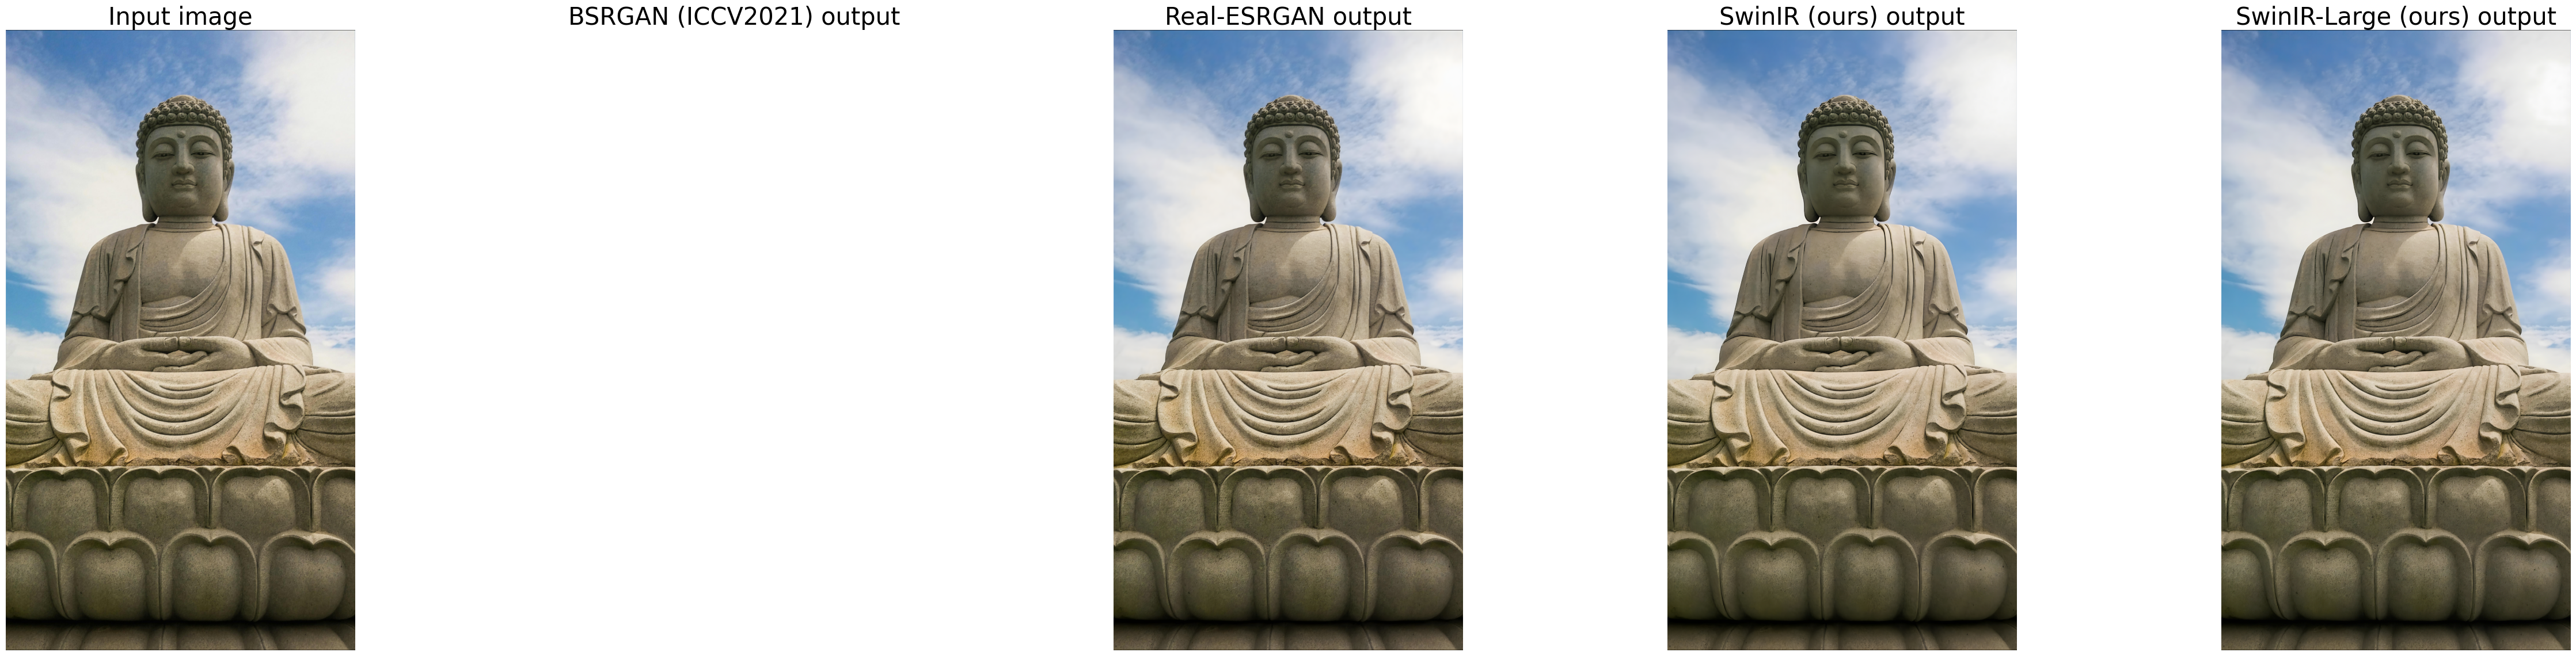

In [18]:
# utils for visualization
import cv2
import matplotlib.pyplot as plt
def display(img1, img2):
  total_figs = 5
  fig = plt.figure(figsize=(total_figs*12, 14))
  ax1 = fig.add_subplot(1, total_figs, 1)
  plt.title('Input image', fontsize=30)
  ax1.axis('off')
  ax2 = fig.add_subplot(1, total_figs, 2)
  plt.title('BSRGAN (ICCV2021) output', fontsize=30)
  ax2.axis('off')
  ax3 = fig.add_subplot(1, total_figs, 3)
  plt.title('Real-ESRGAN output', fontsize=30)
  ax3.axis('off')
  ax4 = fig.add_subplot(1, total_figs, 4)
  plt.title('SwinIR (ours) output', fontsize=30)
  ax4.axis('off')
  ax5 = fig.add_subplot(1, total_figs, 5)
  plt.title('SwinIR-Large (ours) output', fontsize=30)
  ax5.axis('off')
  ax1.imshow(img1)
  ax2.imshow(img2['BSRGAN'])
  ax3.imshow(img2['realESRGAN'])
  ax4.imshow(img2['SwinIR'])
  ax5.imshow(img2['SwinIR-L'])

def imread(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

# display each image in the upload folder
print('Note: BSRGAN may be better at face restoration, but worse at building restoration because it uses different datasets in training.')
if test_patch_wise:
  print('BSRGAN does not support "test_patch_wise" mode for now. Set test_patch_wise = False to see its results.\n')
else:
  print('\n')
input_folder = upload_folder
result_folder = 'results/SwinIR'
input_list = sorted(glob.glob(os.path.join(input_folder, '*')))
output_list = sorted(glob.glob(os.path.join(result_folder, '*')))
for input_path, output_path in zip(input_list, output_list):
  img_input = imread(input_path)
  img_output = {}
  img_output['SwinIR'] = imread(output_path)
  img_output['SwinIR-L'] = imread(output_path.replace('SwinIR/', 'SwinIR_large/').replace('SwinIR.png', 'SwinIR_large.png'))
  if test_patch_wise:
    img_output['BSRGAN'] = img_output['SwinIR']*0+255
  else:
    img_output['BSRGAN'] = imread(output_path.replace('SwinIR', 'BSRGAN'))
  path = output_path.replace('/SwinIR/', '/realESRGAN/').replace('_SwinIR.png','_out{}'.format(os.path.splitext(input_path)[1]))
  if os.path.exists(path):
    shutil.move(path, path.replace('_out.', '_realESRGAN.'))
  img_output['realESRGAN'] = imread(path.replace('_out.', '_realESRGAN.'))

  display(img_input, img_output)

# 5. Download Results


In [19]:
# Download the results
zip_filename = 'SwinIR_result.zip'
if os.path.exists(zip_filename):
  os.remove(zip_filename)
os.system(f"zip -r -j {zip_filename} results/*")
files.download(zip_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>